# Признаки волатильности

- Реализованная волатильность: rolling windows на log_returns
- EWMA-волатильность: экспоненциальное сглаживание
- Parkinson volatility: расчёт на high-low
- Garman-Klass volatility: расчёт на OHLC
- Направленная волатильность: отдельные ап/даун движения

Все расчёты сохраняются структурированно для одного тикера и для всего набора.

-----------------------------------------------------------------

# Гипотеза по модулю!!!

-В данных есть сильный шум из дублирующих признаков.

# 🛠 Рекомендация (не исправлять сейчас, но записать в план) 🛠

В будущем `02_feature_engineering/01_volatility_features.ipynb` нужно будет почистить так:

- Оставить Garman-Klass: Он теоретически наиболее точный (использует OHLC), а корреляция с Parkinson 1.00 позволяет выкинуть Parkinson без потери данных.

- Оставить Realized Volatility: Как базовый "Benchmark".

- Оставить Up_Vol: Уникальная информация (низкая корреляция).

- Удалить Parkinson: Полный дубль GK.

- Удалить EWMA: Дублирует Realized (0.96), либо оставить только EWMA, если важна быстрая реакция, но не оба сразу.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✅ Библиотеки загружены")


✅ Библиотеки загружены


## Загрузка данных

Используем данные из предыдущего этапа `01_data_loading.ipynb`


In [10]:
# Получаем текущую рабочую директорию
current_dir = Path.cwd()
print(f"Текущая директория: {current_dir}")

# Строим путь к данным относительно текущей директории
# Если ноутбук в 'ML/02_feature_engineering/', а данные в 'ML/data/processed'
DATA_DIR = current_dir.parent.parent / "ML" / "data" / "processed"
print(f"Путь к данным: {DATA_DIR}")

# Проверяем существование пути
if DATA_DIR.exists():
    print("Директория найдена!")
else:
    print("Директория не найдена, проверьте путь")

# Пример загрузки для одного тикера
ticker = 'SBER'
df = pd.read_parquet(DATA_DIR / f"{ticker}_ohlcv_returns.parquet")
print(f"Загружено: {len(df)} записей для {ticker}")
print(df.head())


Текущая директория: e:\Python\VolatilityChecker\MOEXScanner\ML\02_feature_engineering
Путь к данным: e:\Python\VolatilityChecker\MOEXScanner\ML\data\processed
Директория найдена!
Загружено: 1301 записей для SBER
     open   close    high     low         value    volume       begin  \
0  205.92  205.03  207.64  204.77  9.481496e+09  46023280  2020-10-13   
1  205.06  207.83  208.00  204.78  9.685023e+09  46840170  2020-10-14   
2  207.46  203.85  207.57  201.95  1.562762e+10  76502030  2020-10-15   
3  204.02  201.17  204.25  200.50  1.339234e+10  66258500  2020-10-16   
4  201.55  202.78  204.00  201.55  9.616800e+09  47421400  2020-10-19   

                   end                date  log_return  
0  2020-10-13 23:59:59 2020-10-13 23:59:59   -0.005593  
1  2020-10-14 23:59:59 2020-10-14 23:59:59    0.013564  
2  2020-10-15 23:59:59 2020-10-15 23:59:59   -0.019336  
3  2020-10-16 23:59:59 2020-10-16 23:59:59   -0.013234  
4  2020-10-19 23:59:59 2020-10-19 23:59:59    0.007971  


## Функции расчета волатильности


In [11]:
def realized_volatility(returns, window=30):
    """Реализованная волатильность: rolling std на log returns"""
    return returns.rolling(window=window).std() * np.sqrt(252)


def ewma_volatility(returns, span=30):
    """EWMA волатильность: экспоненциальное сглаживание"""
    return returns.ewm(span=span).std() * np.sqrt(252)


def parkinson_volatility(high, low, window=30):
    """Parkinson volatility: на основе high-low"""
    hl_ratio = np.log(high / low) ** 2
    return np.sqrt(hl_ratio.rolling(window=window).mean() / (4 * np.log(2))) * np.sqrt(252)


def garman_klass_volatility(open_price, high, low, close, window=30):
    """Garman-Klass volatility: использует OHLC"""
    hl = np.log(high / low) ** 2
    co = np.log(close / open_price) ** 2
    gk = 0.5 * hl - (2 * np.log(2) - 1) * co
    return np.sqrt(gk.rolling(window=window).mean()) * np.sqrt(252)


def directional_volatility(returns, window=30):
    """Направленная волатильность: отдельно вверх и вниз"""
    up_vol = returns[returns > 0].rolling(window=window).std() * np.sqrt(252)
    down_vol = returns[returns < 0].rolling(window=window).std() * np.sqrt(252)
    return up_vol, down_vol

print("✅ Функции волатильности загружены")


✅ Функции волатильности загружены


## Расчет признаков волатильности


✅ Признаки волатильности рассчитаны
                  realized_vol_10  realized_vol_30  ewma_vol_10  \
realized_vol_10          1.000000         0.783970     0.960714   
realized_vol_30          0.783970         1.000000     0.838187   
ewma_vol_10              0.960714         0.838187     1.000000   
parkinson_vol_10         0.973987         0.778633     0.942194   
gk_vol_10                0.960335         0.765722     0.927398   
up_vol_10                0.510437         0.608366     0.570617   
down_vol_10              0.815803         0.783410     0.865859   

                  parkinson_vol_10  gk_vol_10  up_vol_10  down_vol_10  
realized_vol_10           0.973987   0.960335   0.510437     0.815803  
realized_vol_30           0.778633   0.765722   0.608366     0.783410  
ewma_vol_10               0.942194   0.927398   0.570617     0.865859  
parkinson_vol_10          1.000000   0.997191   0.422633     0.828814  
gk_vol_10                 0.997191   1.000000   0.380981     0.8326

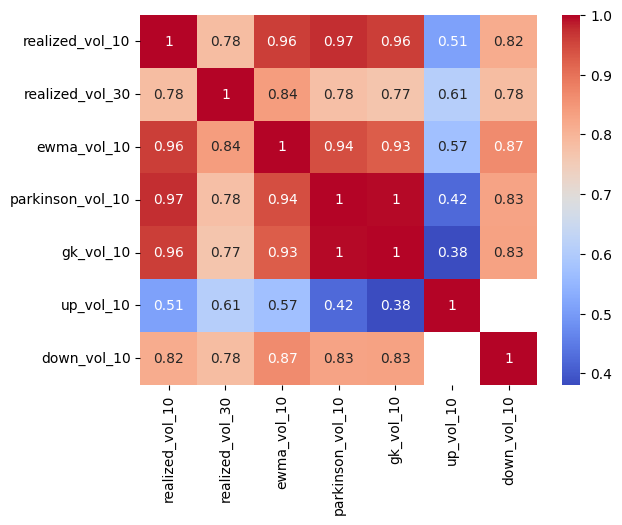

In [ ]:
# Расчет всех типов волатильности
windows = [10, 30, 60]

for window in windows:
    df[f'realized_vol_{window}'] = realized_volatility(df['log_return'], window=window)
    df[f'ewma_vol_{window}'] = ewma_volatility(df['log_return'], span=window)
    df[f'parkinson_vol_{window}'] = parkinson_volatility(df['high'], df['low'], window=window)
    df[f'gk_vol_{window}'] = garman_klass_volatility(df['open'], df['high'], df['low'], df['close'], window=window)
    up, down = directional_volatility(df['log_return'], window=window)
    df[f'up_vol_{window}'] = up
    df[f'down_vol_{window}'] = down

print("✅ Признаки волатильности рассчитаны")
# print(f"\nСтолбцы: {df.columns.tolist()}")
# print(f"\nПример данных:")
# print(df[['date', 'close', 'realized_vol_30', 'ewma_vol_30', 'parkinson_vol_30', 'gk_vol_30', 'up_vol_30', 'down_vol_30']].tail())


vol_cols = [
    'realized_vol_10', 'realized_vol_30', 'ewma_vol_10', 'parkinson_vol_10', 'gk_vol_10', 'up_vol_10', 'down_vol_10',
    
]

# Строим матрицу корреляций
corr_matrix = df[vol_cols].corr()
print(corr_matrix)

# Визуализация
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Сохранение результатов


In [ ]:
# Сохранение с признаками волатильности
OUTPUT_DIR = Path('data') / 'features'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

output_path = OUTPUT_DIR / f"{ticker}_volatility_features.parquet"
df.to_parquet(output_path, index=False)
print(f"✅ Сохранено: {output_path}")
